#Importation des librairies


In [24]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Afin de scale les données
from sklearn.preprocessing import MinMaxScaler

#Afin de séparer le dataset en train/test
from sklearn.model_selection import train_test_split 

#Pour le grid search
from sklearn.model_selection   import GridSearchCV

#Importation des données


In [25]:
dataset = pd.read_csv('online_shoppers_intention.csv', sep=',')
dataset

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [26]:
dataset.shape

(12330, 18)

In [27]:
#On prend 75% des données dans le train et le reste dans le test mais on shuffle d'abord
from sklearn.utils import shuffle

dataset = shuffle(dataset)

app_train = dataset[0:9247]
app_test = dataset[9248:12330]

print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (9247, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
11631,2,18.60,0,0.0,85,2834.280117,0.004884,0.013389,37.423376,0.0,Nov,2,2,1,1,Returning_Visitor,True,False
6520,5,49.20,4,379.0,5,74.600000,0.000000,0.018182,8.326728,0.0,Sep,2,2,8,2,New_Visitor,False,False
2111,4,515.60,0,0.0,77,1449.683333,0.000000,0.002632,0.000000,0.0,May,2,2,4,2,Returning_Visitor,False,False
9273,5,140.25,4,282.0,4,213.500000,0.000000,0.009091,0.000000,0.0,Nov,3,2,1,2,New_Visitor,False,True
8187,0,0.00,0,0.0,4,129.500000,0.000000,0.050000,0.000000,0.0,Dec,8,13,9,20,Other,False,False


#Analyse des données 

In [28]:
dataset['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

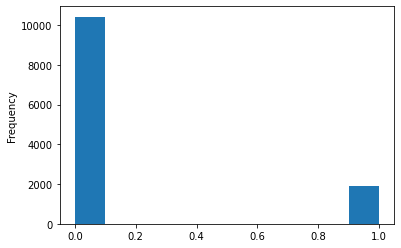

In [29]:
dataset['Revenue'].astype(int).plot.hist();

On peut voir qu'il y a beaucoup plus de visites ou le visiteur n'achète rien que de visites ou il achète 

##Missing values

In [30]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [31]:
missing_values = missing_values_table(dataset)
missing_values.head(20)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Il n'y a aucune valeure manquante dans mon dataset 

##Etudes du type des variables

In [32]:
# le nombre de colonnes pour chaque type de variables
dataset.dtypes.value_counts()

float64    7
int64      7
object     2
bool       2
dtype: int64

In [33]:
# Number of unique classes in each object column
dataset.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Month          10
VisitorType     3
dtype: int64

In [34]:
# Number of unique classes in each boolean column
dataset.select_dtypes('bool').apply(pd.Series.nunique, axis = 0)

Weekend    2
Revenue    2
dtype: int64

On peut voir que mon dataset est composé de 14 variables numériques, de 2 variables boolean et de 2 variables de type texte.

##Etude des variables 

###Variable ProductRelated_Duration

In [35]:
dataset['ProductRelated_Duration'].describe()

count    12330.000000
mean      1194.746220
std       1913.669288
min          0.000000
25%        184.137500
50%        598.936905
75%       1464.157213
max      63973.522230
Name: ProductRelated_Duration, dtype: float64

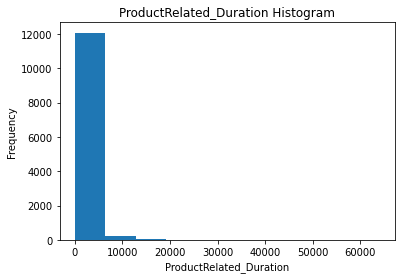

In [36]:
dataset['ProductRelated_Duration'].plot.hist(title = 'ProductRelated_Duration Histogram');
plt.xlabel('ProductRelated_Duration');

On peut voir que en moyenne, un visiteur va rester 1195 secondes sur la page d'un produit. 

###Variable Month

In [37]:
dataset['Month'].describe()

count     12330
unique       10
top         May
freq       3364
Name: Month, dtype: object

Il n'y a que 10 valeurs différentes, ainsi on peut en déduire que tous les mois ne sont pas répertorié

In [38]:
dataset[(dataset.Revenue==True)].groupby('Month').count()['Revenue'].sort_values()

Month
Feb       3
June     29
Jul      66
Aug      76
Sep      86
Oct     115
Mar     192
Dec     216
May     365
Nov     760
Name: Revenue, dtype: int64

On peut voir que les périodes ou il y a le plus d'achats sont :
- octobre, novembre, décembre ce qui peut s'expliquer avec la préparation de noël
- février assez faible malgré la saint-valentin
- période mai, juin, juillet, aout

###Variable Special day

In [39]:
dataset[(dataset.Revenue==True)].groupby('SpecialDay').count()['Revenue'].sort_values()

SpecialDay
1.0      10
0.8      11
0.4      13
0.2      14
0.6      29
0.0    1831
Name: Revenue, dtype: int64

On peut voir que le moment proche des fêtes (comme la saint-valentin ou noel) n'est pas du tout un moment ou les gens achètent spécialement.Attention on ne sait pas combien de jours representent les jours special date, il y a peut être une très forte disproportion de jours entre special date et 0. En effet, si la période d'une special date ne correspond qu'à une dizaine de jours cela ne prendrait en compte seulement les gens qui effectuent leurs achats au dernier moment. 

###Variable Region

In [40]:
dataset[(dataset.Revenue==True)].groupby('Region').count()['Revenue'].sort_values()

Region
5     52
8     56
9     86
6    112
7    119
4    175
2    188
3    349
1    771
Name: Revenue, dtype: int64

On peut voir qu'il y a beaucoup plus d'achat dans les 4 premières régions que dans les autres. Cela correspond peut être à des régions plus riche, plus grande ou plus peuplé. 

###Création variable de la durée totale

In [41]:
app_train['Total_Duration'] = app_train['Administrative_Duration'] + app_train['Informational_Duration'] + app_train['ProductRelated_Duration']
app_test['Total_Duration'] = app_test['Administrative_Duration'] + app_test['Informational_Duration'] + app_test['ProductRelated_Duration']
app_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Total_Duration
11631,2,18.600000,0,0.000000,85,2834.280117,0.004884,0.013389,37.423376,0.0,Nov,2,2,1,1,Returning_Visitor,True,False,2852.880117
6520,5,49.200000,4,379.000000,5,74.600000,0.000000,0.018182,8.326728,0.0,Sep,2,2,8,2,New_Visitor,False,False,502.800000
2111,4,515.600000,0,0.000000,77,1449.683333,0.000000,0.002632,0.000000,0.0,May,2,2,4,2,Returning_Visitor,False,False,1965.283333
9273,5,140.250000,4,282.000000,4,213.500000,0.000000,0.009091,0.000000,0.0,Nov,3,2,1,2,New_Visitor,False,True,635.750000
8187,0,0.000000,0,0.000000,4,129.500000,0.000000,0.050000,0.000000,0.0,Dec,8,13,9,20,Other,False,False,129.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11988,14,228.748539,6,121.583333,336,12166.694240,0.000000,0.012144,0.067050,0.0,Nov,2,2,7,2,Returning_Visitor,False,True,12517.026112
6613,16,314.505000,0,0.000000,37,1048.663333,0.000000,0.008696,87.253963,0.0,Nov,1,1,3,2,New_Visitor,False,True,1363.168333
7637,7,154.933333,0,0.000000,31,910.040000,0.018182,0.052020,5.316109,0.0,Jul,1,1,3,1,Returning_Visitor,False,False,1064.973333
115,0,0.000000,0,0.000000,12,317.833333,0.000000,0.005556,0.000000,0.0,Feb,1,1,1,4,Returning_Visitor,True,False,317.833333


Création d'une variable sur la durée totale passer sur le site de e-commerce. Cela peut donner des informations supplémentaires à nos modèles

#Traitement des variables

##Transformation variable numérique

Il faut d'abord transformer les variables non numérique en variables numériques afin de pouvoir appliquer des modèles de ML au dataset. 

In [42]:
#Je converti les colonnes boolean en colonne numérique afin d'avoir des 0 et des 1 plutôt que True ou False
app_train["Revenue"] = app_train["Revenue"].astype(int)
app_train['Weekend'] = app_train['Weekend'].astype(int)

app_test["Revenue"] = app_test["Revenue"].astype(int)
app_test['Weekend'] = app_test['Weekend'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [43]:
# one-hot encoding pour les variables de type object afin de n'avoir que des variables numérique
app_train = pd.get_dummies(app_train)

app_test = pd.get_dummies(app_test)


In [44]:
app_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Total_Duration,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
11631,2,18.600000,0,0.000000,85,2834.280117,0.004884,0.013389,37.423376,0.0,2,2,1,1,1,0,2852.880117,0,0,0,0,0,0,0,1,0,0,0,0,1
6520,5,49.200000,4,379.000000,5,74.600000,0.000000,0.018182,8.326728,0.0,2,2,8,2,0,0,502.800000,0,0,0,0,0,0,0,0,0,1,1,0,0
2111,4,515.600000,0,0.000000,77,1449.683333,0.000000,0.002632,0.000000,0.0,2,2,4,2,0,0,1965.283333,0,0,0,0,0,0,1,0,0,0,0,0,1
9273,5,140.250000,4,282.000000,4,213.500000,0.000000,0.009091,0.000000,0.0,3,2,1,2,0,1,635.750000,0,0,0,0,0,0,0,1,0,0,1,0,0
8187,0,0.000000,0,0.000000,4,129.500000,0.000000,0.050000,0.000000,0.0,8,13,9,20,0,0,129.500000,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11988,14,228.748539,6,121.583333,336,12166.694240,0.000000,0.012144,0.067050,0.0,2,2,7,2,0,1,12517.026112,0,0,0,0,0,0,0,1,0,0,0,0,1
6613,16,314.505000,0,0.000000,37,1048.663333,0.000000,0.008696,87.253963,0.0,1,1,3,2,0,1,1363.168333,0,0,0,0,0,0,0,1,0,0,1,0,0
7637,7,154.933333,0,0.000000,31,910.040000,0.018182,0.052020,5.316109,0.0,1,1,3,1,0,0,1064.973333,0,0,0,1,0,0,0,0,0,0,0,0,1
115,0,0.000000,0,0.000000,12,317.833333,0.000000,0.005556,0.000000,0.0,1,1,1,4,1,0,317.833333,0,0,1,0,0,0,0,0,0,0,0,0,1


Après avoir fait cela, il ne me reste plus que des variables numérique et je peux donc commencer à appliquer des modèles à mon dataset pour prédire le revenue

##Corrélation des variables

In [45]:
# Find correlations with the target and sort
correlations = app_train.corr()['Revenue'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations)

Most Positive Correlations:
 ExitRates                       -0.205484
BounceRates                     -0.149102
VisitorType_Returning_Visitor   -0.111581
SpecialDay                      -0.082192
Month_May                       -0.071981
Month_Mar                       -0.063058
Month_Feb                       -0.047788
Month_June                      -0.029074
Month_Dec                       -0.028343
OperatingSystems                -0.012299
Region                          -0.010326
Month_Jul                       -0.009570
TrafficType                     -0.004767
Month_Aug                        0.008478
VisitorType_Other                0.010094
Month_Sep                        0.015650
Browser                          0.018226
Weekend                          0.023165
Month_Oct                        0.040555
Informational_Duration           0.073948
Administrative_Duration          0.088745
Informational                    0.098030
VisitorType_New_Visitor          0.111305
Admin

On peut voir que les variables qui ont le plus d'influences sur le Revenue sont : PageValues, ProductRelated, Total_Duration, Month_Nov, ProductRelated_Duration.

Ainsi on peut voir que ajouter la variable Total_Duration était une bonne idée car elle influe beaucoup. On voit aussi que effectivement le mois de novembre a aussi un gros impact, c'est durant ce mois-ci qu'il y avait un maximum de vente.

PageValues a le plus d'impact, on peut donc en déduire que plus un clients surf sur le site plus il est suceptible d'acheter et inversement. 

Pour finir, on observe aussi que les variables ProductRelated et ProductedRelated_Duration on beaucoup d'impact ce qui semble logique. En effet si un client va sur la page d'un produit et le temps qu'il passe sur la page du produit ont forcément beaucoup d'influence sur le passage s'une commande ou non.

##Undersampling

Le but du undersampling est qu'il y est une proportion égale des deux variables du label afin de prévoir plus précisement le label. En effet sinon avec une telle disproportion, il suffit de prédire 100% de valeur comme étant celle ayant le plus d'éléments pour avoir 80% de prédiction juste par exemple. 

J'ai éffectué un premier test sans undersampling et j'ai trouvé des valeurs d'AUC inférieur à celles trouvés en faisant du undersampling dans le train sans rien changer d'autre. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


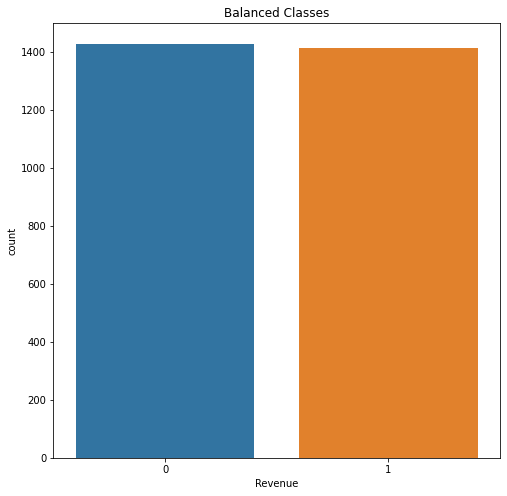

In [46]:
# Put all the target class in a separate dataset.
Revenue_df = app_train.loc[app_train['Revenue'] == 1]

#Randomly select 492 observations from the non-fraud (majority class)
non_Revenue_df = app_train.loc[app_train['Revenue'] == 0].sample(n=1429,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([Revenue_df, non_Revenue_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('Revenue', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

##Je renomme les dataset de train et test

In [47]:
Y_train = normalized_df['Revenue'];
X_train = normalized_df.drop(columns = ['Revenue']);
Y_test = app_test['Revenue'];
X_test = app_test.drop(columns = ['Revenue']);
X_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Total_Duration,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
9273,5,140.250000,4,282.0,4,213.500000,0.000000,0.009091,0.000000,0.0,3,2,1,2,0,635.750000,0,0,0,0,0,0,0,1,0,0,1,0,0
1298,0,0.000000,1,55.0,9,936.833333,0.000000,0.022222,53.255333,0.0,1,1,1,2,1,991.833333,0,0,0,0,0,1,0,0,0,0,0,0,1
11226,3,40.000000,0,0.0,24,3830.000000,0.000000,0.025333,0.000000,0.0,1,1,7,8,0,3870.000000,0,0,0,0,0,0,0,1,0,0,1,0,0
6374,4,19.800000,0,0.0,2,10.000000,0.012500,0.034167,0.000000,0.0,1,1,6,5,1,29.800000,0,0,0,0,0,0,0,0,0,1,1,0,0
11173,2,38.000000,0,0.0,3,33.333333,0.000000,0.030556,0.000000,0.0,2,2,8,10,0,71.333333,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,0,0.000000,0,0.0,6,62.000000,0.000000,0.040000,0.000000,0.0,2,2,1,1,0,62.000000,0,0,0,0,0,1,0,0,0,0,0,0,1
5334,1,32.750000,1,11.0,43,2949.550000,0.015909,0.027165,0.000000,0.8,3,2,1,13,0,2993.300000,0,0,0,0,0,0,1,0,0,0,0,0,1
6448,7,98.466667,0,0.0,13,257.933333,0.000000,0.016000,0.000000,0.0,2,2,3,4,0,356.400000,0,0,0,0,0,0,0,0,0,1,0,0,1
3474,7,71.000000,0,0.0,34,1540.750000,0.004878,0.024390,0.000000,0.0,2,2,8,3,0,1611.750000,0,0,0,0,0,0,1,0,0,0,0,0,1


In [48]:
Y_train.describe()

count    2844.000000
mean        0.497539
std         0.500082
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Revenue, dtype: float64

##Scaling des variables

In [49]:
#On n'effectue un scaling des données afin e normaliser les variables

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[0.20833333, 0.05277878, 0.30769231, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07692308, ..., 0.        , 0.        ,
        1.        ],
       [0.125     , 0.01505277, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.29166667, 0.0370549 , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.29166667, 0.02671867, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

#Modèle de regression logistique

In [50]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.001)

# Train on the training data
log_reg.fit(X_train, Y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
# Make predictions
# We select the second column to know the probability of a loan not being paid
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

##Calcul des résultats du modèle

In [52]:
pred_reg_f1 = log_reg_pred
for i in range(len(pred_reg_f1)) :
  if (pred_reg_f1[i] > 0.5) :
    pred_reg_f1[i] = 1
  else :
    pred_reg_f1[i] = 0

pred_reg_f1

array([0., 0., 1., ..., 1., 0., 1.])

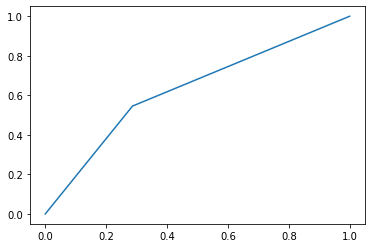

0.6295209017398464


In [53]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(Y_test, log_reg_pred)
x = fpr # false_positive_rate
y = tpr # true_positive_rate 

# This is the ROC curve
plt.plot(x,y)
plt.show() 

# This is the AUC
auc = np.trapz(y,x)
print(auc)

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,pred_reg_f1)

Text(33.0, 0.5, 'Truth')

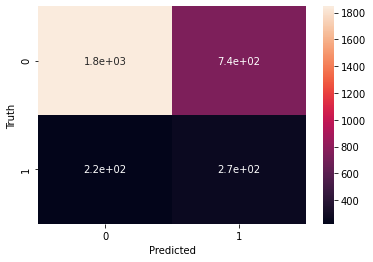

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(6,4))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Test d'un random forest grid search

In [58]:
def RandomForest_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Random Forest
    """
    import sys, pickle
    from sklearn.ensemble          import RandomForestClassifier
    from sklearn.model_selection   import GridSearchCV
    from sklearn.metrics           import make_scorer
    from sklearn.preprocessing     import label_binarize
    from sklearn.multiclass        import OneVsRestClassifier
    #grid search :

    parameters = {  "n_estimators"         : [ 10, 100, 200 ], 
                    "min_samples_leaf"     : [  3,   1,   7 ],
                    "criterion"            : ["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    "class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    
    grid_type = "RandomForestClassifier"
    
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search 
    """
    
    # Exhaustive Grid Search : will try all parameters combinations
    # vs RandomizedSeachCV where the model test random combinations.
    
    grid         = GridSearchCV(RandomForestClassifier(), {})#, parameters, verbose=1, scoring='f1_weighted')
    
    try :grid.fit(df, Y)
    except Exception as e : print ("[%s - 2] : %s"%(grid_type,e) )
    
    print (" best_score_ %s with =  %s "%( grid.best_score_,  grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid.best_estimator_

In [59]:
# Apprentissage du classifieur RF sur X_train et Y_train (<nb_lignes> données)
rf = RandomForest_grid_search(X_train, Y_train)


------------------------------ 
 RandomForestClassifier
 best_score_ 0.8540824030297779 with =  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 


In [60]:
#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
predictions2 = rf.predict(X_test)

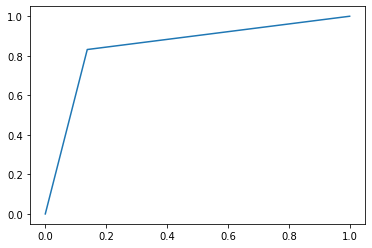

0.8468759621961224


In [61]:
import sklearn.metrics as metrics

fpr2, tpr2, threshold2 = metrics.roc_curve(Y_test, predictions2)
x2 = fpr2 # false_positive_rate
y2 = tpr2 # true_positive_rate 

# This is the ROC curve
plt.plot(x2,y2)
plt.show() 

# This is the AUC
auc2 = np.trapz(y2,x2)
print(auc2)

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,predictions2)

Text(33.0, 0.5, 'Truth')

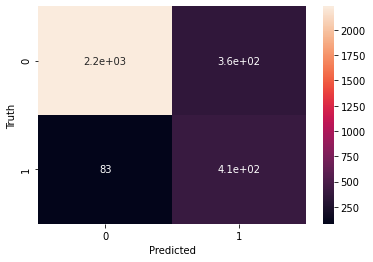

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(6,4))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Test random forest basique

In [64]:
#On importe l'algorithme à partir de sklearn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
#Et on lance le training sur notre dataset de train
rf = rf.fit(X_train, Y_train)

In [65]:
#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
predictions = rf.predict(X_test)

In [66]:
predictions

array([1, 0, 0, ..., 1, 1, 1])

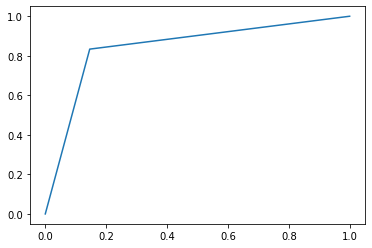

0.8438345410486087


In [67]:
y_probas2 = predictions# predicted probabilities generated by sklearn classifier

fpr2, tpr2, threshold2 = metrics.roc_curve(Y_test, y_probas2)
x2 = fpr2 # false_positive_rate
y2 = tpr2 # true_positive_rate 

# This is the ROC curve
plt.plot(x2,y2)
plt.show() 

# This is the AUC
auc2 = np.trapz(y2,x2)
print(auc2)

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,predictions)

Text(33.0, 0.5, 'Truth')

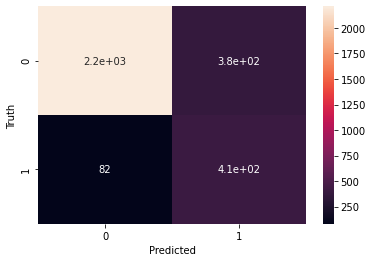

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(6,4))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

##Sauvegarde modèle


In [70]:
import pickle
pickle.dump(rf, open('final_prediction_rf.pickle', 'wb'))

In [71]:
X_test[2]

array([0.20833333, 0.09637537, 0.15384615, 0.04541521, 0.00749064,
       0.01392704, 0.        , 0.05      , 0.        , 0.        ,
       0.        , 0.        , 0.625     , 0.05263158, 0.        ,
       0.02236172, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        ])

In [72]:
Y_test

3944     1
4244     0
7144     0
3442     0
2736     0
        ..
4647     0
875      0
12134    0
57       0
11052    0
Name: Revenue, Length: 3082, dtype: int64

#Test d'un XGBoost

In [73]:
pip install xgboost

In [74]:
from xgboost import XGBClassifier
algo = XGBClassifier()

In [75]:
default_hyperparameters = algo.get_params()
espace_de_Recherche = {}
for i, hyperparam in enumerate(default_hyperparameters):
    default_value = default_hyperparameters[hyperparam]
    if default_value:
        if type(default_value) == int:
            delta = default_value * 2
            valeurs_de_recherches = [default_value-delta,default_value, default_value+ delta]
        if type(default_value) == float:
            delta = default_value * 0.1
            valeurs_de_recherches = [default_value-delta,default_value, default_value+ delta]
        if type(default_value) == bool:
            valeurs_de_recherches = [True, False]
        espace_de_Recherche[hyperparam]=valeurs_de_recherches
        print(hyperparam, default_value, valeurs_de_recherches)
espace_de_Recherche["n_jobs"]=[-1]

base_score 0.5 [0.45, 0.5, 0.55]
booster gbtree [0.45, 0.5, 0.55]
colsample_bylevel 1 [-1, 1, 3]
colsample_bynode 1 [-1, 1, 3]
colsample_bytree 1 [-1, 1, 3]
learning_rate 0.1 [0.09, 0.1, 0.11000000000000001]
max_depth 3 [-3, 3, 9]
min_child_weight 1 [-1, 1, 3]
n_estimators 100 [-100, 100, 300]
n_jobs 1 [-1, 1, 3]
objective binary:logistic [-1, 1, 3]
reg_lambda 1 [-1, 1, 3]
scale_pos_weight 1 [-1, 1, 3]
subsample 1 [-1, 1, 3]
verbosity 1 [-1, 1, 3]


In [76]:
def test_hyperparametres(algo, hyperparametres):
    grid       = GridSearchCV(algo, hyperparametres, n_jobs=-1)
    grid.fit(X_train, Y_train)
    print (grid.best_score_, grid.best_estimator_)    
    return grid.best_score_, grid.best_estimator_

In [77]:
espace_de_Recherche = {
    "max_depth" : [1,5,10],
    "gamma" : [0.5, 1, 1.1, 1.2, 1.5]
}
test_hyperparametres(XGBClassifier(), espace_de_Recherche)

0.855138741057947 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.2,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


(0.855138741057947,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=1.2,
               learning_rate=0.1, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1))

In [78]:
modele = algo.fit(X_train, Y_train)

In [79]:
#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
predict_xgb_reg = modele.predict(X_test)

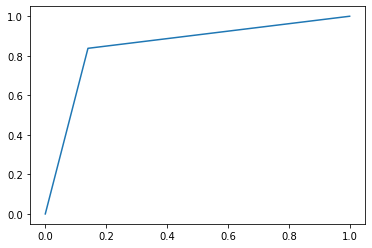

0.8487598099934424


In [80]:
fpr2, tpr2, threshold2 = metrics.roc_curve(Y_test, predict_xgb_reg)
x2 = fpr2 # false_positive_rate
y2 = tpr2 # true_positive_rate 

# This is the ROC curve
plt.plot(x2,y2)
plt.show() 

# This is the AUC
auc2 = np.trapz(y2,x2)
print(auc2)

Je trouve un AUC meilleur qu'avec le random forest. C'est donc mon meilleur modèle pour prédire si un visiteur va effectuer un achat ou non lors de sa visite 

In [81]:
predict_xgb_reg_bin = predict_xgb_reg
for i in range(len(predict_xgb_reg_bin)) :
  if (predict_xgb_reg_bin[i] > 0.5) :
    predict_xgb_reg_bin[i] = 1
  else :
    predict_xgb_reg_bin[i] = 0

predict_xgb_reg_bin

array([1, 0, 0, ..., 1, 1, 1])

Text(33.0, 0.5, 'Truth')

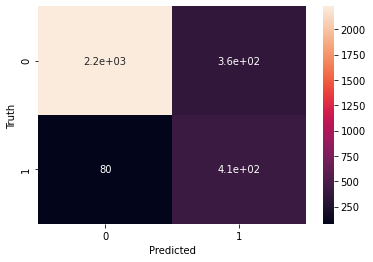

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,predict_xgb_reg_bin)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(6,4))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Grâce à cette confusion matrice, on peut voir que notre modèle prédit peu de faux 0. Cela correspond que peu de clients qui vont passer une commande sont prédit comme ne passant pas de commande. Par contre le modèle prédit beaucoup plus de faux 1. Il prédit beaucoup plus de clients comme allant passé une commande alors qu'ils n'en passeront pas.

##Sauvegarde modèle


In [ ]:
import pickle
pickle.dump(modele, open('final_prediction.pickle', 'wb'))

In [ ]:
X_test[2]

array([0.07692308, 0.00676719, 0.        , 0.        , 0.02247191,
       0.00444715, 0.        , 0.07142857, 0.        , 0.        ,
       0.14285714, 0.08333333, 0.25      , 0.05263158, 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        ])

In [ ]:
Y_test

9668     0
9863     0
12263    0
4945     1
6028     0
        ..
10260    0
7917     0
434      0
4753     0
6883     0
Name: Revenue, Length: 3082, dtype: int64

#Conclusion

En conclusion, on peut voir qu'entre la date de visite d'un site d'e-commerce et le temps passé sur chaque page de ce site, c'est surtout le temps passé sur chaque page de ce site qui déterminera si un client passera une commande ou non. Le but pour le site d'e-commerce sera donc de garder le plus longtemps possible ses clients sur son site et de les pousser à visiter des pages d'autres produits. De plus le mois de novembre influe le plus sur les commandes, cela est surement du à la préparation de noël. Ainsi c'est à cette période que le campagne de pub peuvent avoir le plus d'impact. Pour finir, mon modèle XGBoost permet de prévoir de manière assez précise si un client va passer une commande ou non. Cela peut aussi être utilisé pour essayer de maximiser les commandes